In [2]:
from multiprocessing.sharedctypes import Value
import sys
import os
from getopt import getopt
from models.seqlab import DNABERT_SL
from utils.seqlab import NUM_LABELS, Index_Dictionary, preprocessing_kmer
from transformers import BertForMaskedLM, BertTokenizer
import json
import torch
from tqdm import tqdm
from utils.metrics import Metrics
import wandb
import numpy as np
import pandas as pd

c:\.virtualenv\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# args = parse_args(sys.argv[1:])
# for key in args.keys():
#     print(f"# {key} - {args[key]}")

# use static input first.
args = {
    "device": "cuda:0",
    "model-config": os.path.join("models", "config", "seqlab", "base.json"),
    "model-checkpoint": os.path.join("run", "sso01-adamw-lr5e-5-base.lin1-2w1boplw", "latest", "checkpoint.pth"),
    "test-config": os.path.join("training", "config", "seqlab", "ss-only.01.lr5e-5.json"),
    "log": os.path.join("prediction", "sso01-adamw-lr5e-5-base.lin1-2w1boplw")
}

device = args.get("device", "cpu") # specify device or use cpu otherwise.

model_config_path = args.get("model-config", False)
model_checkpoint = args.get("model-checkpoint", False)
test_config_path = args.get("test-config")
test_config = json.load(open(test_config_path, "r"))
test_file = test_config.get("test_data", False)

if not model_config_path:
    raise ValueError("model config not specified.")
if not os.path.exists(model_config_path):
    raise ValueError(f"model config not exists at {model_config_path}")
print(f"using model config at {model_config_path}")
    
if not model_checkpoint:
    raise ValueError("model checkpoint not specified.")
if not os.path.exists(model_checkpoint):
    raise ValueError(f"model checkpoint not exists at {model_checkpoint}")
print(f"found model checkpoint at {model_checkpoint}")

if not test_file:
    raise ValueError("test not specified.")
if not os.path.exists(test_file):
    raise ValueError(f"test file not exists at {test_file}")
print(f"found test data at {test_file}")

bert_for_masked_lm = BertForMaskedLM.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
model = DNABERT_SL(
    bert_for_masked_lm.bert, # bert, 
    json.load(open(model_config_path, "r")) # config
)

checkpoint = torch.load(model_checkpoint, map_location=device)
model.load_state_dict(checkpoint.get("model"))
model.eval()
model.to(device)

tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))

using model config at models\config\seqlab\base.lin1.json
found model checkpoint at run\sso01-adamw-lr5e-5-base.lin1-2w1boplw\latest\checkpoint.pth
found test data at workspace\seqlab-latest\gene_index.01_test_ss_all_pos.csv


Preparing Data gene_index 01_test_ss_all_pos: 100%|██████████| 6961/6961 [00:49<00:00, 141.85it/s]


In [ ]:
# loading data.
batch_size = 1
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


In [5]:
logdir = os.path.join("prediction", "log")
os.makedirs(logdir, exist_ok=True)
print(f"found log directory at {logdir}")

# initialize wandb.
run = wandb.init(
    project="prediction",
    entity="anwari32"
)
wandb.define_metric("prediction_step")
wandb.define_metric("prediction/*", step_metric="prediction_step")

found log directory at prediction\log


In [6]:
result = []
prediction_step = 0
device = "cuda:0"
model.to(device)
df_data = {}
token_f1_scores = {}
token_precision = {}
token_recall = {}

for i in range(NUM_LABELS):
    label = Index_Dictionary[i]
    token_f1_scores[label] = []
    token_precision[label] = []
    token_recall[label] = []

for step, batch in tqdm(enumerate(test_dataloader), total=test_size, desc="Testing"):
    input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        predictions, bert_output = model(input_ids, attn_mask)
        for inputs, pred, target_label in zip(input_ids, predictions, target_labels):
            vals, pred_ids = torch.max(pred, 1)
            input_ids_list = inputs.tolist()
            pred_ids_list = pred_ids.tolist()
            target_list = target_label.tolist()
            
            # log to local first.
            input_ids_str = [str(a) for a in input_ids_list]
            input_ids_str = " ".join(input_ids_str)
            pred_ids_str = [str(a) for a in pred_ids_list]
            pred_ids_str = " ".join(pred_ids_str)
            target_ids_str = [str(a) for a in target_list]
            target_ids_str = " ".join(target_ids_str)

            actual_input_ids = input_ids_list[1:] # remove CLS token
            actual_input_ids = [t for t in actual_input_ids if t > 0]
            actual_target_ids = target_list[1:] # remove CLS token
            actual_target_ids = [a for a in actual_target_ids if a >= 0]
            actual_pred_ids = pred_ids_list[1:] # remove CLS prediction
            actual_pred_ids = actual_pred_ids[0:len(actual_target_ids)]

            metrics = Metrics(actual_pred_ids, actual_target_ids)
            metrics.calculate()
            for label_idx in range(NUM_LABELS):
                precision = metrics.precision(label_idx)
                recall = metrics.recall(label_idx)
                f1_score = metrics.f1_score(label_idx)
                label_name = Index_Dictionary[label_idx]
                wandb.log({
                    f"prediction/precision-{label_name}": precision,
                    f"prediction/recall-{label_name}": recall,
                    f"prediction/f1_score-{label_name}": f1_score,
                    "prediction_step": prediction_step
                })
                token_f1_scores[label_name].append(f1_score)
                token_precision[label_name].append(precision)
                token_recall[label_name].append(recall)

            prediction_step += 1

for k in token_f1_scores.keys():
    df_data[f"f1_score-{k}"] = token_f1_scores[k]
    df_data[f"precision-{k}"] = token_precision[k]
    df_data[f"recall-{k}"] = token_recall[k]

df = pd.DataFrame(data=df_data)
df.to_csv(os.path.join(logdir, "prediction_log.csv"),index=False)

run.finish()

Testing: 100%|██████████| 6961/6961 [07:43<00:00, 15.02it/s]


prediction/f1_score-EEE,▂▃▁▁▁▁▁▁▃█▆▄▃▄▇▅▆▇▇▁▁▂▁▅█▆▃▅▆▅▅▇██▆▅▂▂▆▄
prediction/f1_score-EEi,▁▁▁▁▁▁▆▁▆▁▁▁▆▅▆▁███▁▁▁▆▆█▆███▆█▆▅▆▆██▁▁▁
prediction/f1_score-EiE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
prediction/f1_score-Eii,▁▆▁▁▁▁▆█▆▁▁▁█▁▆▁███▁▁▁▆▆█▅███▆█▆▅▆███▁▁▁
prediction/f1_score-iEE,▁▁▁▁▁▁█▆██▃▆▁▁▁▁▁▂▆▆▁▁▁▅█▄▂▆▅▂▁███▃▅▂▁▁▁
prediction/f1_score-iEi,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
prediction/f1_score-iiE,▁▁▁▁▁▁█▆████▁▁▁█▁█▆▆▁▁▁███▅▆▆▄▁████▆█▁▆▁
prediction/f1_score-iii,▅▆█▇▇█████▇▃▁▆█████▆▃▆▆▇█▇▆▇▇▇▇███▇▇▇▇▇▂
prediction/precision-EEE,▃▂▁▁▁▁▁▁████▇▇▇██▇████▁▄█▄▃▄▅▄▄▆██▅▄▂▂██
prediction/precision-EEi,▁▁▁▁▁▁▅▁▅▁▁▁▅▃▅▁███▁▁▁▅▅█▅███▅█▅▃▅▅██▁▁▁
prediction/precision-EiE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
import os
import pandas as pd

logpath = os.path.join("prediction", "log", "prediction_log.csv")
df = pd.read_csv(logpath)
df["f1_score_total"] = df["f1_score-iii"] + df["f1_score-iiE"] + df["f1_score-iEE"] + df["f1_score-iiE"] + df["f1_score-iEE"] + df["f1_score-EEE"] 
df.head()
df.to_csv(logpath, index=False)


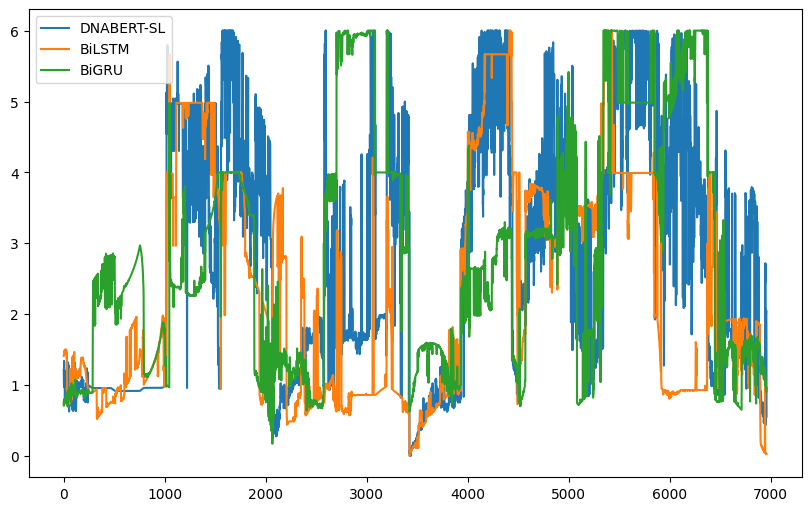

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

logpath = os.path.join("prediction", "log", "prediction_log.csv")

df = pd.read_csv(logpath)

token_labels = labels = ["iii", "EEE", "iEE", "iiE", "Eii", "EEi"]
xs = [i for i in range(df.shape[0])]

figs, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(8, 7))


plt.suptitle("Prediction Result")
plt.show()

    
    

In [12]:
tokenizer

PreTrainedTokenizer(name_or_path='pretrained\3-new-12w-0', vocab_size=69, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [33]:
from torch import tensor
from torch.utils.data import TensorDataset, DataLoader
from utils.seqlab import Label_Dictionary, _process_label, Index_Dictionary
from utils.metrics import Metrics
from tqdm import tqdm

test_df = pd.read_csv(test_file)
print(test_df.head())

unique_label_sequences = np.unique(test_df["label"])
print(unique_label_sequences.shape)
num_classes = 8

device = "cuda:0"
model.to(device)

unique_label_sequences_ids = []
unique_label_sequences_names = []
unique_label_sequence_counter = 0
average_f1_score = {}
average_precision = {}
average_recall = {}

error_analysis_log = {}
error_analysis_log["label_sequence_id"] = []
error_analysis_log["input_ids"] = []
error_analysis_log["prediction"] = []
error_analysis_log["target"] = []
error_analysis_log["step"] = []

for i in range(num_classes):
    k = Index_Dictionary[i]
    average_f1_score[k] = []
    average_precision[k] = []
    average_recall[k] = []
    error_analysis_log[f"f1_score-{k}"] = []
    error_analysis_log[f"precision-{k}"] = []
    error_analysis_log[f"recall-{k}"] = []


print(error_analysis_log.keys())
prediction_step = 0

for label_sequence in tqdm(unique_label_sequences, total=unique_label_sequences.shape[0], desc="Predicting"):
    unique_label_sequences_ids.append(unique_label_sequence_counter)
    unique_label_sequences_names.append(label_sequence)

    cur_df = test_df[test_df["label"] == label_sequence]
    this_df_f1_score = {}
    this_df_precision = {}
    this_df_recall = {}
    for i in range(num_classes):
        label_name = Index_Dictionary[i]
        this_df_f1_score[label_name] = []
        this_df_precision[label_name] = []
        this_df_recall[label_name] = []

    for i, r in cur_df.iterrows():
        sequence = r["sequence"]
        encoded_sequence = tokenizer.encode_plus(sequence)
        input_ids = encoded_sequence.get("input_ids")
        attention_mask = encoded_sequence.get("attention_mask")
        target_label = r["label"]
        target_label_ids = _process_label(target_label)

        arr_input_ids = [input_ids]
        arr_input_ids = tensor(arr_input_ids)
        arr_attention_mask = [attention_mask]
        arr_attention_mask = tensor(arr_attention_mask)
        arr_label_ids = [target_label_ids]
        arr_label_ids = tensor(arr_label_ids)

        y_pred, bert_output = model(
            arr_input_ids.to(device), 
            arr_attention_mask.to(device)
        )

        y_pred_index = torch.argmax(y_pred, 2).flatten()
        y_pred_index = y_pred_index.tolist()

        # Clean up.
        target_label_ids = target_label_ids[1:] # remove CLS token.
        target_label_ids = [t for t in target_label_ids if t >= 0]
        y_pred_ids = y_pred_index[1:] # remove CLS token.
        y_pred_ids = y_pred_ids[0:len(target_label_ids)]

        # log input and output in error_analysis_log
        error_analysis_log["step"].append(
            prediction_step
        )
        prediction_step += 1

        error_analysis_log["label_sequence_id"].append(
            unique_label_sequence_counter
        )
        error_analysis_log["input_ids"].append(
            tokenizer.decode(input_ids, skip_special_tokens=True)
        )
        error_analysis_log["prediction"].append(
            ' '.join([str(a) for a in y_pred_ids])
        )
        error_analysis_log["target"].append(
            ' '.join([str(a) for a in target_label_ids])
        )

        metrics = Metrics(y_pred_ids, target_label_ids)
        metrics.calculate()
        
        for i in range(num_classes):
            label_name = Index_Dictionary[i]
            this_df_f1_score[label_name].append(metrics.f1_score(i))
            this_df_precision[label_name].append(metrics.precision(i))
            this_df_recall[label_name].append(metrics.recall(i))
            error_analysis_log[f"f1_score-{label_name}"].append(metrics.f1_score(i))
            error_analysis_log[f"precision-{label_name}"].append(metrics.precision(i))
            error_analysis_log[f"recall-{label_name}"].append(metrics.recall(i))
        

    for i in range(num_classes):
        k = Index_Dictionary[i]
        average_f1_score[k].append(np.average(this_df_f1_score[k]))
        average_precision[k].append(np.average(this_df_precision[k]))
        average_recall[k].append(np.average(this_df_recall[k]))

    unique_label_sequence_counter += 1


data = {}
data["label_sequence_id"] = unique_label_sequences_ids
data["label_sequence_name"] = unique_label_sequences_names
for i in range(num_classes):
    label_name = Index_Dictionary[i]
    data[f"average-f1_score-{label_name}"] = average_f1_score[label_name]
    data[f"average-precision-{label_name}"] = average_precision[label_name]
    data[f"average-recall-{label_name}"] = average_recall[label_name]

result_df = pd.DataFrame(data=data)
result_df.to_csv(
    os.path.join("prediction", "error_analysis.csv"), 
    index=False,
)

for k in error_analysis_log.keys():
    print(f"{k} {len(error_analysis_log[k])}")

error_analysis_log_df = pd.DataFrame(data=error_analysis_log)
error_analysis_log_df.to_csv(
    os.path.join("prediction", "error_analysis_log.csv"),
    index=False
)


                                            sequence  \
0  TCA CAT ATT TTG TGT GTG TGA GAC ACC CCT CTG TG...   
1  CAT ATT TTG TGT GTG TGA GAC ACC CCT CTG TGG GG...   
2  ATT TTG TGT GTG TGA GAC ACC CCT CTG TGG GGG GG...   
3  TTG TGT GTG TGA GAC ACC CCT CTG TGG GGG GGA GA...   
4  TGT GTG TGA GAC ACC CCT CTG TGG GGG GGA GAG AG...   

                                               label  
0  EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EE...  
1  EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EE...  
2  EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EE...  
3  EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EE...  
4  EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EE...  
(4553,)
dict_keys(['label_sequence_id', 'input_ids', 'prediction', 'target', 'step', 'f1_score-iii', 'precision-iii', 'recall-iii', 'f1_score-iiE', 'precision-iiE', 'recall-iiE', 'f1_score-iEi', 'precision-iEi', 'recall-iEi', 'f1_score-Eii', 'precision-Eii', 'recall-Eii', 'f1_score-iEE', 'precision-iEE', 'recall-iEE', 'f1_score-EEi

Predicting: 100%|██████████| 4553/4553 [11:50<00:00,  6.40it/s]


label_sequence_id 6961
input_ids 6961
prediction 6961
target 6961
step 6961
f1_score-iii 6961
precision-iii 6961
recall-iii 6961
f1_score-iiE 6961
precision-iiE 6961
recall-iiE 6961
f1_score-iEi 6961
precision-iEi 6961
recall-iEi 6961
f1_score-Eii 6961
precision-Eii 6961
recall-Eii 6961
f1_score-iEE 6961
precision-iEE 6961
recall-iEE 6961
f1_score-EEi 6961
precision-EEi 6961
recall-EEi 6961
f1_score-EiE 6961
precision-EiE 6961
recall-EiE 6961
f1_score-EEE 6961
precision-EEE 6961
recall-EEE 6961


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

error_analysis_df = pd.read_csv(
    os.path.join("prediction", "error_analysis.csv")
)

error_analysis_df.head(10)
token_labels = ["iii", "EEE", "iEE", "iiE", "Eii", "EEi"]
summary_df = {}
for token_label in token_labels:
    summary_df["average-f1_score"] = np.average(
        error_analysis_df[f"average-f1_score-{token_label}"]
    )
    summary_df["max-f1_score"] = np.max(
        error_analysis_df[f"average-f1_score-{token_label}"]
    )
    summary_df["min-f1_score"] = np.min(
        error_analysis_df[f"average-f1_score-{token_label}"]
    )
    summary_df["average-precision"] = np.average(
        error_analysis_df[f"average-precision-{token_label}"]
    )
    summary_df["average-recall"] = np.average(
        error_analysis_df[f"average-recall-{token_label}"]
    )

summary_df

{'average-f1_score': 0.5576926450901027,
 'max-f1_score': 1.0,
 'min-f1_score': 0.0,
 'average-precision': 0.5145578909248743,
 'average-recall': 0.6568118352106931}

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

error_analysis_df = pd.read_csv(
    os.path.join("prediction", "error_analysis_log_sorted.csv")
)

y_pred = []
y_target = []
for i, r in error_analysis_df.iterrows():
    prediction = r["prediction"]
    prediction = [int(a) for a in prediction.split(" ")]
    y_pred = y_pred + prediction
    target = r["target"]
    target = [int(a) for a in target.split(" ")]
    y_target = y_target + target

print(len(y_pred))
print(len(y_target))

3550110
3550110


In [10]:
from utils.seqlab import Index_Dictionary

classes = [i for i in range(8)]
print(f"Token   Precision   Recall  F1 Score")
pred_metrics = Metrics(y_pred, y_target)
pred_metrics.calculate()
for i in classes:
    print(f"{Index_Dictionary[i]}   {pred_metrics.precision(i)}  {pred_metrics.recall(i)} {pred_metrics.f1_score(i)}")

Token   Precision   Recall  F1 Score
iii   0.839  0.901 0.869
iiE   0.46  0.657 0.541
iEi   0  0 0
Eii   0.505  0.736 0.599
iEE   0.059  0.678 0.109
EEi   0.482  0.719 0.577
EiE   0  0 0
EEE   0.614  0.42 0.499


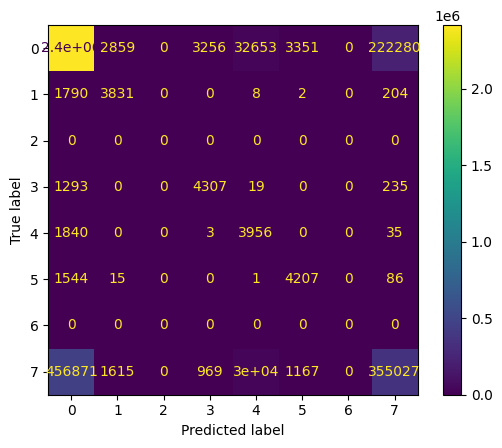

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = [i for i in range(8)]

cm = confusion_matrix(y_target, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [38]:
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sn

plot_confusion_matrix(
    y_target,
    y_pred,
    title="DNABERT-SL Lin1 Confusion Matrix",
)
plt.show()

NameError: name 'y_target' is not defined

In [36]:
import os
from utils.metrics import Metrics
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils.seqlab import Index_Dictionary

log_val_path = os.path.join("run", "sso01-adamw-lr5e-5-base.lin1-2w1boplw", "validation_log.4.csv")
lin1_val_df = pd.read_csv(log_val_path)

lin1_y_pred = []
lin1_y_target = []
for i, r in tqdm(lin1_val_df.iterrows(), total=lin1_val_df.shape[0], desc="Reading"):
    target = r["target"].split(" ")
    target = [int(a) for a in target]
    target = target[1:] # remove CLS
    target = [a for a in target if a >= 0]
    prediction = r["prediction"].split(" ")
    prediction = [int(a) for a in prediction]
    prediction = prediction[1:] # remove CLS
    prediction = prediction[0:len(target)]

    lin1_y_pred += prediction
    lin1_y_target += target

lin1_metrics = Metrics(lin1_y_pred, lin1_y_target)
lin1_metrics.calculate()
classes = [i for i in range(8)]
print(f"Token   Precision   Recall  F1 Score")
for i in classes:
    print(f"{Index_Dictionary[i]}   {lin1_metrics.precision(i)}  {lin1_metrics.recall(i)} {lin1_metrics.f1_score(i)}")


Reading: 100%|██████████| 17717/17717 [00:08<00:00, 2131.95it/s]


Token   Precision   Recall  F1 Score
iii   0.999  0.998 0.998
iiE   0.797  0.987 0.882
iEi   0  0 0
Eii   0.873  1.0 0.932
iEE   0.735  0.991 0.844
EEi   0.873  0.999 0.932
EiE   0  0 0
EEE   0.997  0.996 0.996


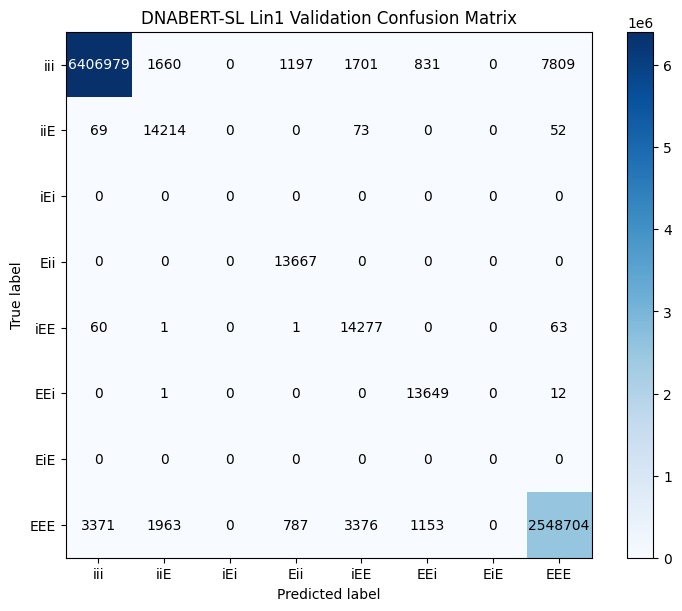

In [37]:
from scikitplot.metrics import plot_confusion_matrix
plt.rcParams['figure.constrained_layout.use'] = True
axes = plot_confusion_matrix(
    lin1_y_target,
    lin1_y_pred,
    title="DNABERT-SL Lin1 Validation Confusion Matrix",
    labels=[i for i in range(8)],
    figsize=(8, 6)
)
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

In [2]:
import os
from utils.metrics import Metrics
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils.seqlab import Index_Dictionary

log_val_path = os.path.join("run", "sso01-adamw-lr5e-5-base-291mo307", "validation_log.4.csv")
base_df = pd.read_csv(log_val_path)

base_y_pred = []
base_y_target = []
for i, r in tqdm(base_df.iterrows(), total=base_df.shape[0], desc="Reading"):
    target = r["target"].split(" ")
    target = [int(a) for a in target]
    target = target[1:] # remove CLS
    target = [a for a in target if a >= 0]
    prediction = r["prediction"].split(" ")
    prediction = [int(a) for a in prediction]
    prediction = prediction[1:] # remove CLS
    prediction = prediction[0:len(target)]

    base_y_pred += prediction
    base_y_target += target

base_metrics = Metrics(base_y_pred, base_y_target)
base_metrics.calculate()
classes = [i for i in range(8)]
print(f"Token   Precision   Recall  F1 Score")
for i in classes:
    print(f"{Index_Dictionary[i]}   {base_metrics.precision(i)}  {base_metrics.recall(i)} {base_metrics.f1_score(i)}")


Reading: 100%|██████████| 17717/17717 [00:06<00:00, 2795.14it/s]


Token   Precision   Recall  F1 Score
iii   0.999  0.996 0.997
iiE   0.722  0.999 0.838
iEi   0  0 0
Eii   0.847  0.992 0.914
iEE   0.676  0.997 0.806
EEi   0.826  0.992 0.901
EiE   0  0 0
EEE   0.994  0.995 0.994


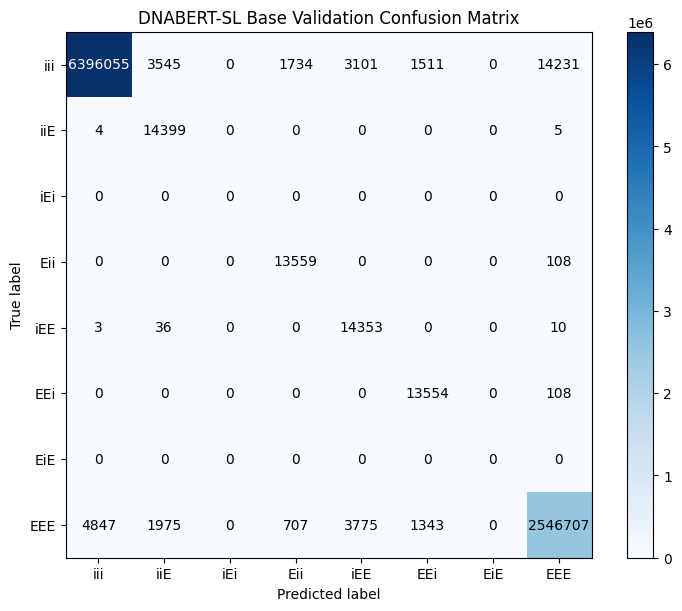

In [34]:
from scikitplot.metrics import plot_confusion_matrix
from utils.seqlab import Index_Dictionary
import matplotlib.pyplot as plt
labels = [Index_Dictionary[i] for i in range(8)]
plt.rcParams['figure.constrained_layout.use'] = True
axis = plot_confusion_matrix(
    base_y_target,
    base_y_pred,
    title="DNABERT-SL Base Validation Confusion Matrix",
    labels=[i for i in range(8)],
    figsize=(8, 6)
)
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

In [31]:
axis

<AxesSubplot:title={'center':'DNABERT-SL Base Validation Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

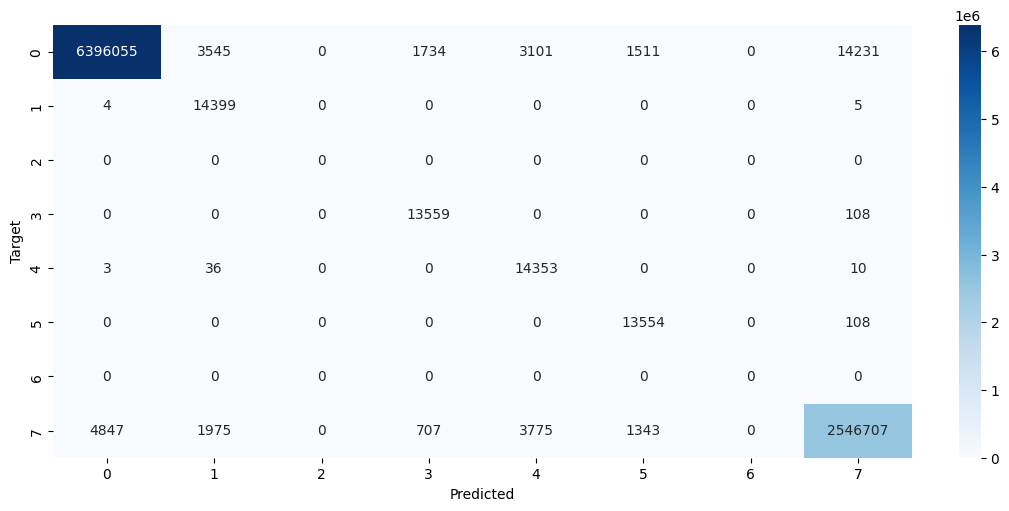

In [27]:
import seaborn as sns
import numpy as np
confusion_matrix = np.array(base_metrics.matrix).transpose() 
ax = sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='d')
ax.set(xlabel="Predicted", ylabel="Target")
plt.show()